In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set_context("talk")
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/"

# load families summary
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.dataset == "homfam"]
families = summary_homfam.drop(["subset", "file", "min_length", "max_length", "perc_ref_total", "dataset"], axis = 1)

# Load similarities 
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
sims = os.path.join(evaluation_dir,"homfam/evaluation/sim/*FAMSA.MBED.sim")
sim_df = pd.DataFrame()
for file in list(glob.glob(sims)):
    full_name = file.split(sep = "/")[-1].replace(".sim", "")
    file_opened = open(file, "r")
    tot_line = [line.split() for line in file_opened if line.startswith('TOT')]
    entry = pd.DataFrame({'name': [full_name],"sim_tot": tot_line[0][3]})
    sim_df =  pd.concat([sim_df, entry], ignore_index = True)

    
sim_df["family"] = sim_df.name.str.split(".", expand = True)[0]
sim_df["family"] = sim_df.family.str.replace("-ref", "")
sim_df = sim_df.rename(columns = {"sim_tot": "sim"})
families = pd.merge(families,sim_df)
families["family_real"]= families.family
families["family"] = families.family_real+"-ref"
families = families.drop(["family_real", "name"], axis = 1)
families["sim"] = families.sim.astype(float)

# 1. PREP SCORES
def get_scores(score_files): 
    def parse_score(score_file): 
        return(pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1))

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:4]
    scores.columns = ['name', 'sp', 'tc', 'column']
    return(scores)


def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "tc", size_fig = 1): 
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    
    hue = df[hue_var]
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
    # Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")
    
    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = hue_var,
                    s = 100,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    
    ax.set(xlim = (0,100), ylim = (0,100))
    ax.get_legend().remove()
    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")




def get_traces(traces): 
    def parse_trace(trace):
        dataset = os.path.dirname(trace).split("/")[-2]
        family = os.path.dirname(trace).split("/")[-1]
        df = pd.read_csv(trace, sep = "=").T
        df["dataset"] = dataset
        df["family"] = family
        return(df.reset_index())

    traces = pd.concat(list(map(parse_trace, traces)))
    return(traces)

In [4]:
glob.glob('/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/alphabet/3di/*/.command.trace')

[]

In [5]:
glob.glob(os.path.join(data_dir, "alphabet/*/*/.command.trace"))

[]

In [6]:
# 0. GET RUNNING TIME LIBRARIES
trace_files = (glob.glob(os.path.join(data_dir, "libraries/*/*/.command.trace")))
traces_df = get_traces(trace_files)
traces_df["running_time (s)"] = traces_df.realtime/1000


# subselect where there are the 3 of them 
filter_traces =  traces_df[traces_df.family.isin(set(traces_df[traces_df.dataset == "TMalign_pair"].family))]
filter_traces["dataset"] = pd.Categorical(filter_traces.dataset, ["sequence", "foldseek", "TMalign_pair"])

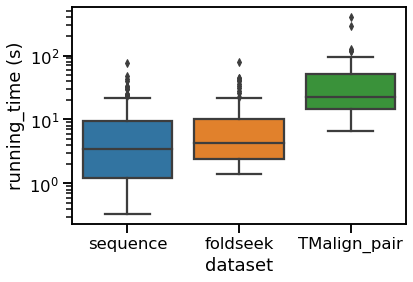

In [7]:
sns.boxplot(data = filter_traces, x = "dataset", y = "running_time (s)" )
plt.yscale('log')

## COLLECT SCORES 

In [8]:
# 1. SEQUENCE SCORES 
sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*progressive.PROBAPAIR.MBED*")))
sequence_scores[["family", "method", "align_method", "tree_method"]] = sequence_scores.name.str.split(".", expand = True)
sequence_scores = pd.merge(sequence_scores, families, on = "family")
sequence_scores["library_method"] = "sequence"

# 2. FOLDSEEK SCORES 
foldseek_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_only*")))
foldseek_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_scores.name.str.split(".", expand = True)
foldseek_scores = pd.merge(foldseek_scores, families, on = "family")

# 3. FOLDSEEK_SEQUENCE
foldseek_sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_sequence*")))
foldseek_sequence_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_sequence_scores.name.str.split(".", expand = True)
foldseek_sequence_scores = pd.merge(foldseek_sequence_scores, families, on = "family")

# 4. 3DCOFFEE STRUCTURE 
structures_3dcoffee_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*3DCOFFEE.MBED*")))
structures_3dcoffee_scores[["family", "method", "align_method", "tree_method"]] = structures_3dcoffee_scores.name.str.split(".", expand = True)
structures_3dcoffee_scores = pd.merge(structures_3dcoffee_scores, families, on = "family")
structures_3dcoffee_scores["library_method"]  = "tmAlign"

In [10]:
scores = pd.concat([sequence_scores,foldseek_sequence_scores,structures_3dcoffee_scores, foldseek_scores])
scores["align_method"] = pd.Categorical(scores.align_method, ["PROBAPAIR", "foldseek", "3DCOFFEE"])
scores["library_method"] = pd.Categorical(scores.library_method, ["sequence", "tmAlign", "foldseek_only", "foldseek_sequence"])


[Text(0.5, 0, 'avg % similarity')]

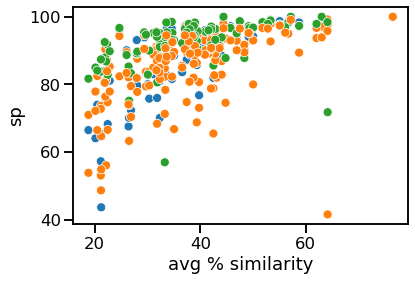

In [11]:
ax = sns.scatterplot(data = scores, hue = "align_method", y = "sp", x = "sim")
ax.get_legend().remove()
ax.set(xlabel = "avg % similarity")

In [28]:
# How do we do in the families with tricky infos? 
#prob_families = 'cryst,msb,HLH,LIM,oxidored_q6,serpin,toxin,int,ins,rhv,myb_DNA-binding,hr,ChtBD,tms,bowman,mmp,tgfb,adh,phc'
#prob_families = prob_families.split(",")
scores["fam_clean"] = scores.family.str.replace("-ref", "")
#scores_prob = scores[scores.fam_clean.isin(prob_families)]
scores_prob=scores

In [13]:
#scores_prob = scores_prob[scores_prob.library_method.isin(["tmAlign", "sequence"])]

In [25]:
scores_prob = scores_prob[scores_prob.library_method.isin(["foldseek_only", "foldseek_sequence"])]

In [26]:
scores_prob

,name,sp,tc,column,family,method,align_method,tree_method,n_sequences,mean_length,size_group,sim,library_method,fam_clean
0,tgfb-ref.foldseek.MBED.foldseek_sequence,90.9,56.4,63.6,tgfb-ref,NaN,foldseek,MBED,1606,95.464508,small,43.12,foldseek_sequence,tgfb
1,hom-ref.foldseek.MBED.foldseek_sequence,92.0,60.9,72.1,hom-ref,NaN,foldseek,MBED,12037,53.495140,large,34.60,foldseek_sequence,hom
2,blm-ref.foldseek.MBED.foldseek_sequence,97.4,89.5,92.5,blm-ref,NaN,foldseek,MBED,9105,300.726524,medium,38.98,foldseek_sequence,blm
3,scorptoxin-ref.foldseek.MBED.foldseek_sequence,92.9,72.6,82.7,scorptoxin-ref,NaN,foldseek,MBED,363,53.256198,small,46.90,foldseek_sequence,scorptoxin
4,cyclo-ref.foldseek.MBED.foldseek_sequence,86.9,69.3,72.8,cyclo-ref,NaN,foldseek,MBED,6288,159.069338,medium,44.06,foldseek_sequence,cyclo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,cytb-ref.foldseek.MBED.foldseek_only,92.5,73.9,81.4,cytb-ref,NaN,foldseek,MBED,3206,82.145352,small,34.72,foldseek_only,cytb
89,glob-ref.foldseek.MBED.foldseek_only,84.2,25.3,30.0,glob-ref,NaN,foldseek,MBED,3983,100.683656,small,31.70,foldseek_only,glob
90,rnasemam-ref.foldseek.MBED.foldseek_only,90.8,64.9,75.9,rnasemam-ref,NaN,foldseek,MBED,498,120.072289,small,42.07,foldseek_only,rnasemam
91,sodcu-ref.foldseek.MBED.foldseek_only,82.7,63.3,66.4,sodcu-ref,NaN,foldseek,MBED,2038,141.322375,small,42.65,foldseek_only,sodcu


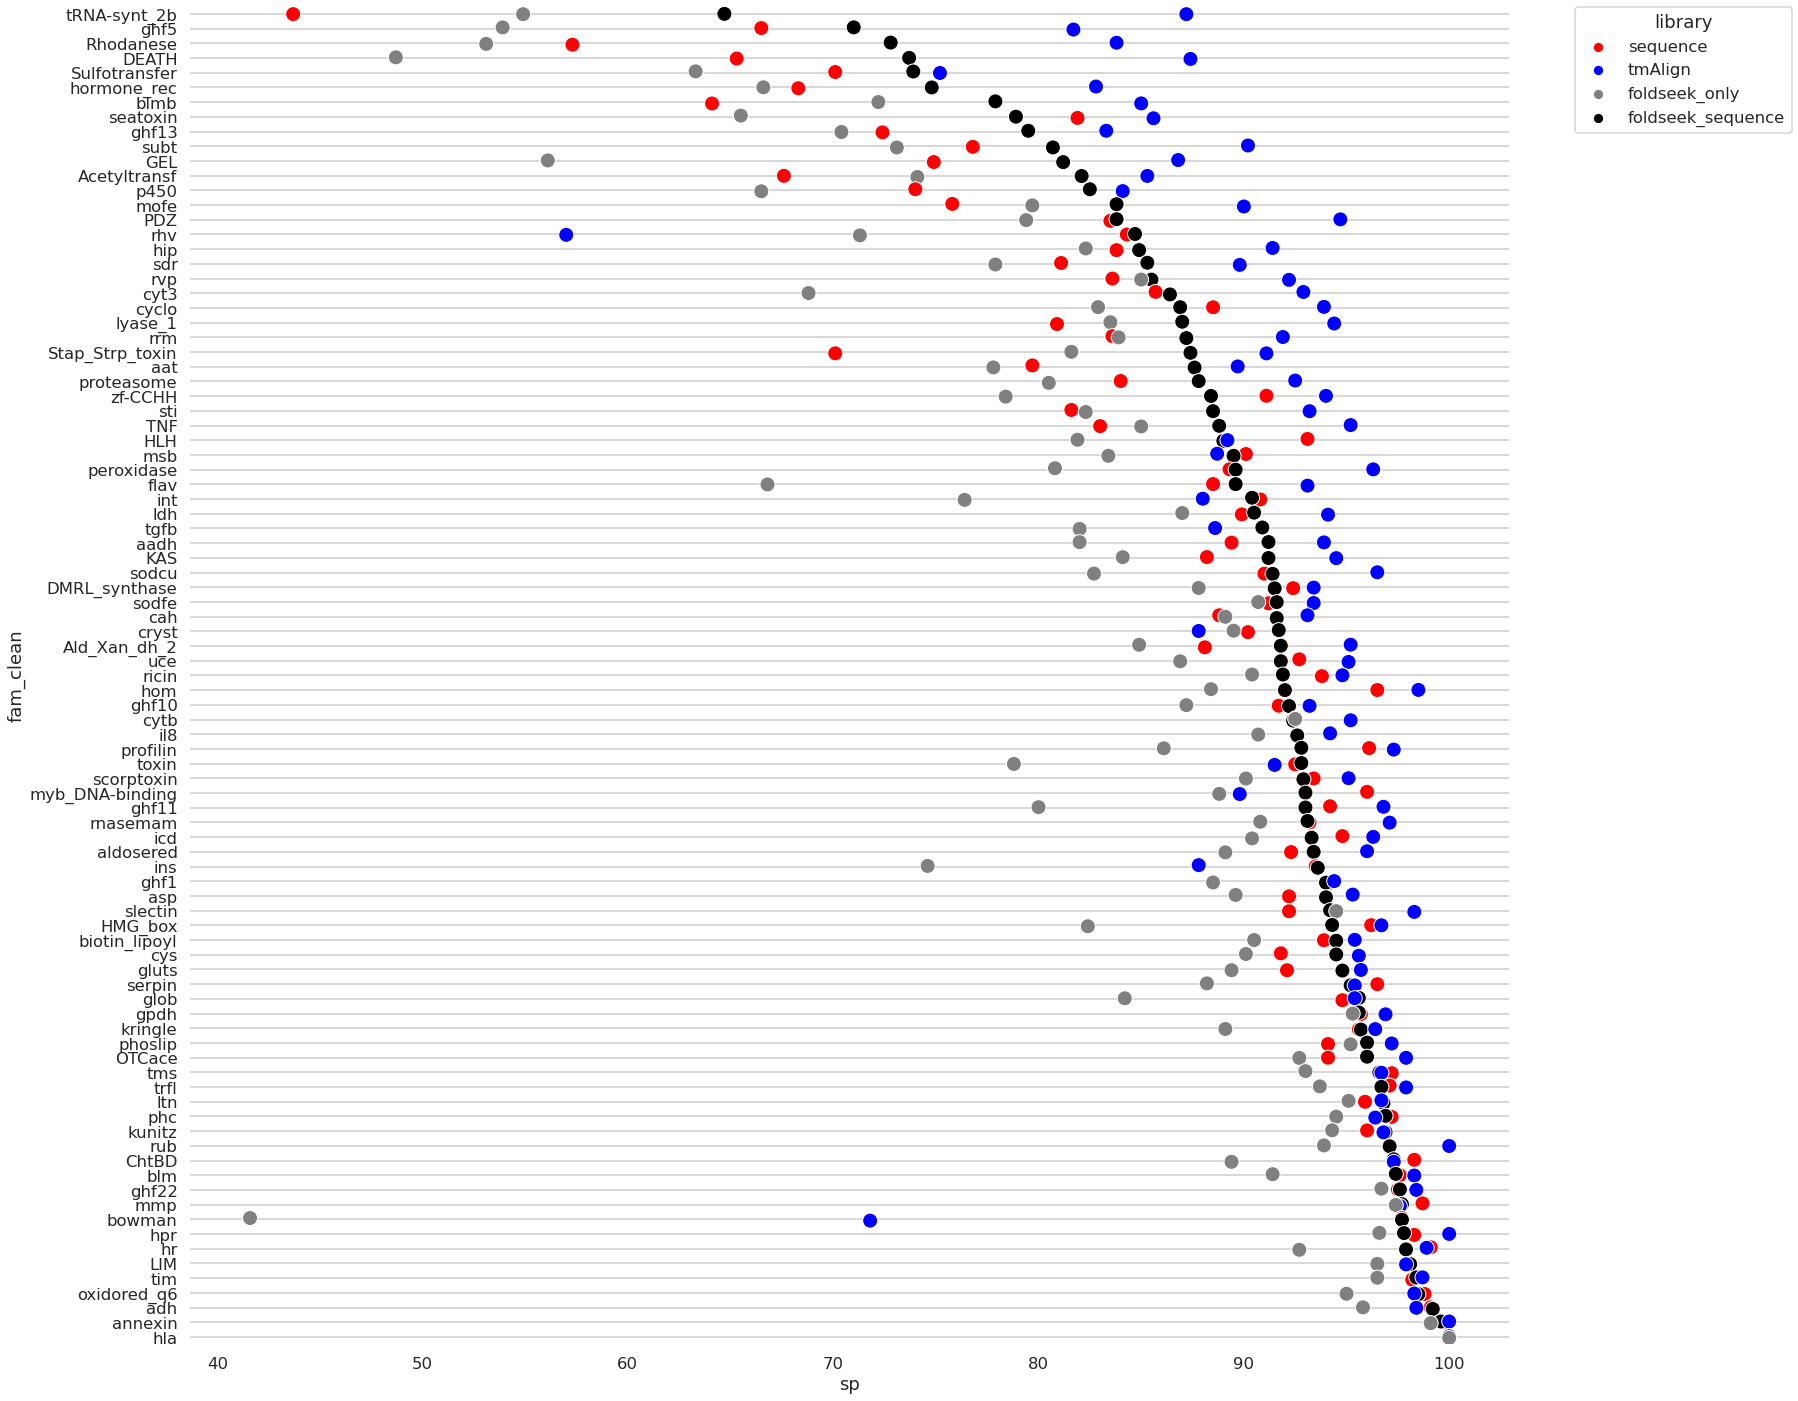

In [29]:
#plot = plt.scatter(df["family"], df["corr"], c=df["sp_3D"], cmap='Reds')
#plt.clf()
#cbar = plt.colorbar(plot)
#cbar.set_label('sp_3D', rotation=270)
import itertools
sns.set_theme(style="whitegrid")
sns.set_context("talk")



sorter = scores_prob[scores_prob.library_method == "foldseek_sequence"].sort_values("sp").family.to_frame()
scores_prob = pd.merge(sorter,scores_prob, on = "family", how = 'left')

# Create an array with the colors you want to use
colors = list(itertools.chain.from_iterable([["red", "blue", "grey", "black", "grey", "grey"],["orange"]*100]))

#colors = ["red", "blue", "grey", "black", "grey", "grey", rep(c("orag"))]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))


g = sns.PairGrid(scores_prob,
                 x_vars="sp", y_vars=["fam_clean"], hue = "library_method",
                 height=20, aspect=1)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=True,
       linewidth=1, edgecolor="w")


for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "library")



## Does foldseek_sequence improve accuracy over homfam? 

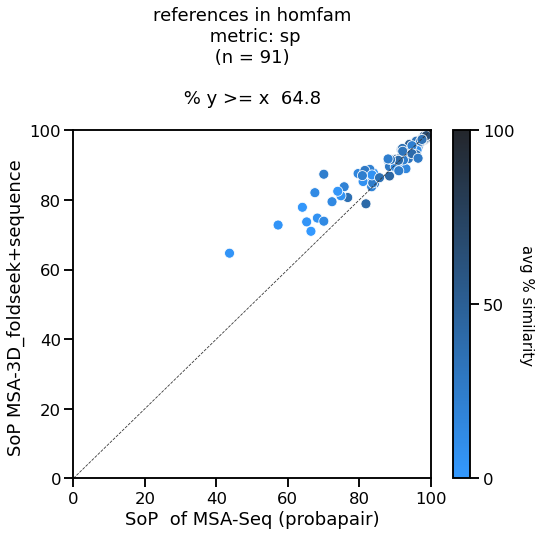

In [8]:
plot_scatter_perc(sequence_scores, foldseek_sequence_scores,  "SoP  of MSA-Seq (probapair)", "SoP MSA-3D_foldseek+sequence ", metric = "sp", title = "references in homfam", hue_var = "sim")

## Does combining foldseek and sequence improve performance? 

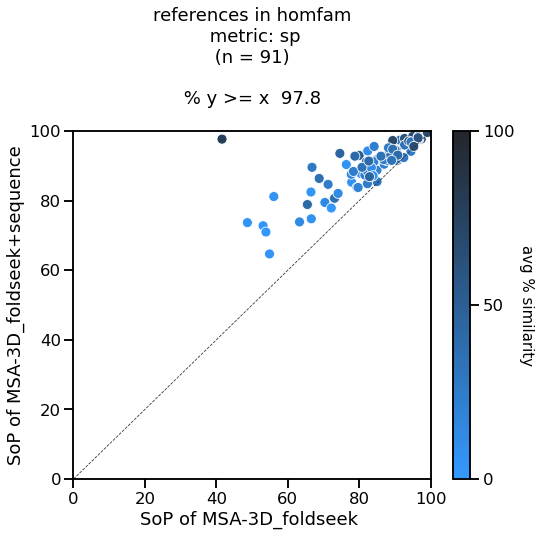

In [9]:
plot_scatter_perc(foldseek_scores,foldseek_sequence_scores, "SoP of MSA-3D_foldseek ", "SoP of MSA-3D_foldseek+sequence",metric = "sp", title = "references in homfam")

## How do we do compared to standard 3D coffee? 

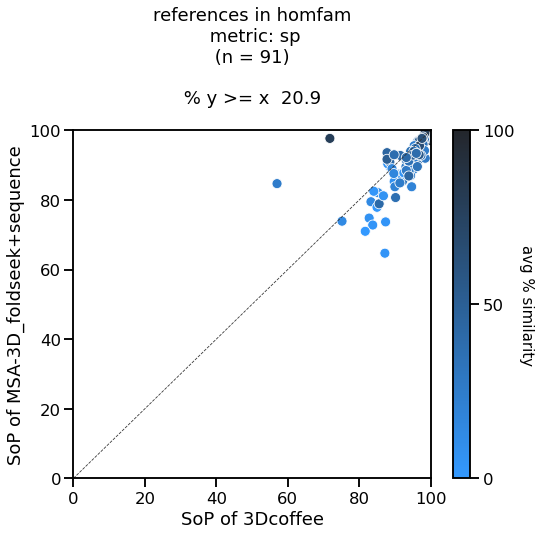

In [11]:
plot_scatter_perc(structures_3dcoffee_scores,foldseek_sequence_scores, "SoP of 3Dcoffee", "SoP of MSA-3D_foldseek+sequence",metric = "sp", title = "references in homfam")

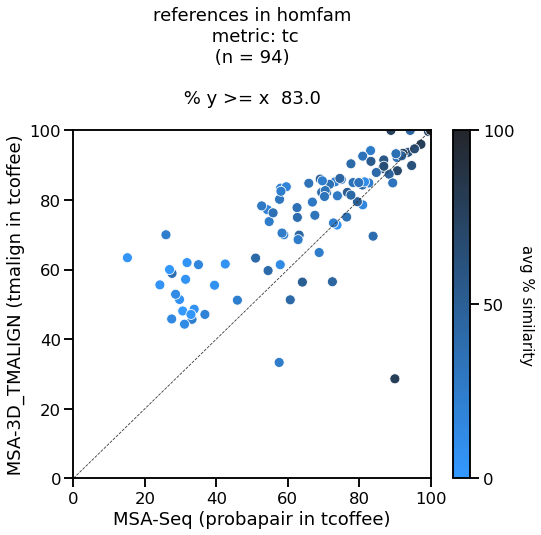

In [9]:
plot_scatter_perc(sequence_scores, structures_3dcoffee_scores, "MSA-Seq (probapair in tcoffee)", " MSA-3D_TMALIGN (tmalign in tcoffee) ", metric = "tc", title = "references in homfam")

In [10]:
pd.merge(sequence_scores,structures_3dcoffee_scores, on = "family" )["sp"]

KeyError: 'sp'